In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/work/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
fname = '/home/dnash/SEAK_clim_data/downloads/SEAK_flood_catalog.csv'
df = pd.read_csv(fname)
df = df.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9','Unnamed: 10', 'Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14'], axis=1)
df = df.set_index(pd.to_datetime(df['Impact dates']))
start_date = '2000-01-01'
end_date = '2019-12-31'
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]
df

,Impact Level,Impact dates,Impact,Impact Information,Impact Source,Notes
Impact dates,,,,,,
2019-12-27,2,12/27/2019,Lake Flooding,"minor flooding at ward lake, trails and some c...",ARDAT,NaN
2019-12-27,2,12/27/2019,Lake Flooding,"minor flooding at ward lake, trails and some c...",ARDAT,NaN
2019-11-22,1,11/22/2019,Flood stage; action stage,Ketchikan creek at 3rd highest crest; Thorne r...,AHPS,NaN
2019-11-22,0,11/22/2019,Action stage,Thorne River at 8th highest overflow,AHPS,NaN
2019-11-17,0,11/17/2019,Action stage,Jordan Creek at 11th highest crest,AHPS,NaN
...,...,...,...,...,...,...
2000-07-24,2,07/24/2000,Residential and street flooding',"Basements flooded along water street, small cr...",APRFC,23rd had the 24th highest precip at 4.72
2000-07-24,2,07/24/2000,Residential and street flooding',"Basements flooded along water street, small cr...",APRFC,This event followed 2 ar events
2000-07-13,1,07/13/2000,"Flooding, action stage","Alsek at 10th highest overflow, minor flooding...",NWS,This is not in AR database; 07/12/2000 - 07/13...


In [7]:
df = df.drop_duplicates(subset=['Impact dates'])
df

,Impact Level,Impact dates,Impact,Impact Information,Impact Source,Notes
Impact dates,,,,,,
2019-12-27,2,12/27/2019,Lake Flooding,"minor flooding at ward lake, trails and some c...",ARDAT,NaN
2019-11-22,1,11/22/2019,Flood stage; action stage,Ketchikan creek at 3rd highest crest; Thorne r...,AHPS,NaN
2019-11-17,0,11/17/2019,Action stage,Jordan Creek at 11th highest crest,AHPS,NaN
2019-10-15,1,10/15/2019,Lake Flooding,"minor flooding at ward lake, some trails and c...",APRFC,The 16th had the 27th highest precip
2019-10-06,4,10/06/2019,FLooding; landslides; erosion,Flooding all over juneau and douglas; douglas ...,"NWS, APRFC, HYDRO",NaN
...,...,...,...,...,...,...
2000-09-04,1,09/04/2000,Flood stage,Indian river at 10th highest crest,AHPS,NaN
2000-08-22,2,08/22/2000,Flooding,Flooding along POW along small creeks and logg...,APRFC,NaN
2000-07-24,2,07/24/2000,Residential and street flooding',"Basements flooded along water street, small cr...",APRFC,23rd had the 24th highest precip at 4.72


In [8]:
df.groupby('Impact Level').size()

Impact Level
0    55
1    32
2    48
3    15
4     2
5     2
dtype: int64

In [9]:
test = df.groupby([df.index.month, 'Impact Level']).size()
test

Impact dates  Impact Level
1             0                4
              2                4
              4                1
2             0                2
3             0                1
              2                1
              3                1
5             0                1
              2                1
6             0                4
              1                3
              2                3
7             0                9
              1                3
              2                6
              3                2
8             0                6
              1                8
              2               14
              3                5
              5                1
9             0               16
              1                9
              2               15
              3                4
10            0                4
              1                5
              2                1
              3                2
              4 

<AxesSubplot:xlabel='Impact dates'>

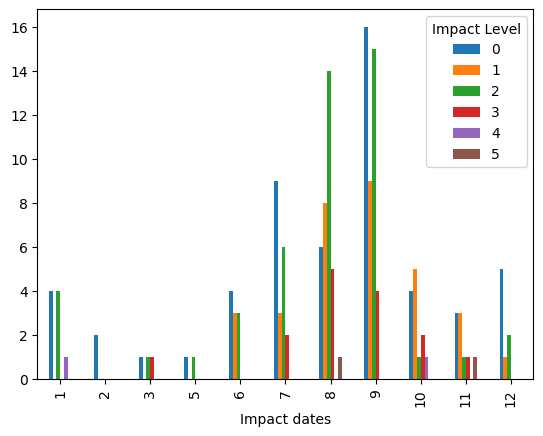

In [10]:
test.unstack('Impact Level').plot.bar()